# Solve Ayagari (1994)


The Ayagari economy is as the previous quesitons but with more possible states. To solve that economy I will base my code on that that can be found at Quantitative Economics, which is an open source website for modeling economics. 


The main characteristics of the ayagari economy is that it uses a CRRA utility function. It sets $\alpha=0.36$ and $\delta=0.08$. Furthermore, there are seven possible states, which is the main difference with our previous model .


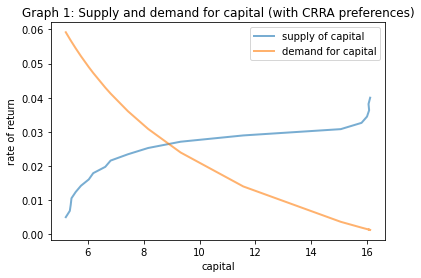

In [1]:
import numpy as np
from numba import jit
import quantecon as qe
import matplotlib.pyplot as plt
from quantecon.markov import DiscreteDP


class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i 

    To invert this map, use
    
        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                 r=0.01,                      # interest rate
                 w=1.0,                       # wages
                 β=1/(1+0.04),                # discount factor
                 a_min=1e-10,
                 Π=[[0.6, 0.4], [0.4, 0.6]],  # Markov chain
                 z_vals=[0.3, 1.3],           # exogenous states
                 a_max=18,
                 a_size=100):

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)


@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = (pow(c,1-4)-1)/(1-4)   # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

@jit(nopython=True)
def consumption_marginal(s_probs, a_size, z_size):
    c_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            c_probs[a_i] += s_probs[a_i * z_size + z_i]
    return c_probs

#Parameters
A = 1.0 
N = 1.0  #Normalized labor (to 1)
α = 0.33 #Capital share
β = 1/(1+0.04)
δ = 0.05  #Depreciation


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=30)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.set_xlabel('capital')
ax.set_ylabel('rate of return')
ax.legend(loc='upper right')
plt.title('Graph 1: Supply and demand for capital (with CRRA preferences)')

plt.show()

Text(0.5, 1.0, 'Graph 2: Stationary distribution of assets')

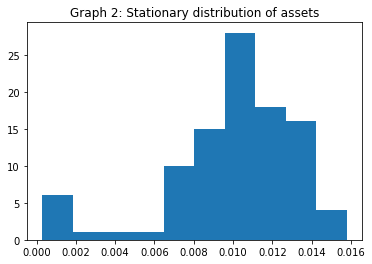

In [2]:
# Report the endogenous distribution of wealth. 

#STEP 1: Stationary distribution of wealth. 
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
# Compute the stationary distribution
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

#PLOT
plt.hist(asset_probs)
plt.title('Graph 2: Stationary distribution of assets')

## Ayagari General Equilibrium: 


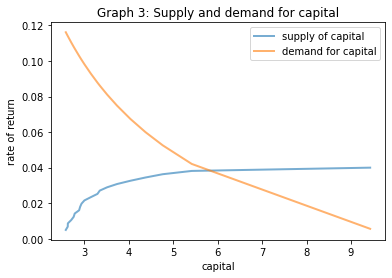

In [3]:
class Household:
    """
    This class takes the parameters that define a household asset accumulation
    problem and computes the corresponding reward and transition matrices R
    and Q required to generate an instance of DiscreteDP, and thereby solve
    for the optimal policy.

    Comments on indexing: We need to enumerate the state space S as a sequence
    S = {0, ..., n}.  To this end, (a_i, z_i) index pairs are mapped to s_i
    indices according to the rule

        s_i = a_i * z_size + z_i 

    To invert this map, use
    
        a_i = s_i // z_size  (integer division)
        z_i = s_i % z_size

    """


    def __init__(self,
                 r=0.01,                # interest rate
                 w=1.0,                 # wages
                 β=0.96,                # discount factor
                 a_min=0,
                 Π=[[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05], [0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05], [0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05],[0.05, 0.15, 0.2, 0.2, 0.2, 0.15,0.05]],  # Markov chain
                 z_vals=[0.01, 0.2, 0.4, 0.6, 0.8, 1, 1.2],
                 a_max=18,
                 a_size=100):

 #Some comments on the stochastic income process: the code does not work if we 
 #include negative states; we do not very well how to get the transition probabilities
 #so, we came up with a creative transition matrix, that it's different from Aiyagari's one. 

        # Store values, set up grids over a and z
        self.r, self.w, self.β = r, w, β
        self.a_min, self.a_max, self.a_size = a_min, a_max, a_size

        self.Π = np.asarray(Π)
        self.z_vals = np.asarray(z_vals)
        self.z_size = len(z_vals)

        self.a_vals = np.linspace(a_min, a_max, a_size)
        self.n = a_size * self.z_size

        # Build the array Q
        self.Q = np.zeros((self.n, a_size, self.n))
        self.build_Q()

        # Build the array R
        self.R = np.empty((self.n, a_size))
        self.build_R()

    def set_prices(self, r, w):
        """
        Use this method to reset prices.  Calling the method will trigger a
        re-build of R.
        """
        self.r, self.w = r, w
        self.build_R()

    def build_Q(self):
        populate_Q(self.Q, self.a_size, self.z_size, self.Π)

    def build_R(self):
        self.R.fill(-np.inf)
        populate_R(self.R, self.a_size, self.z_size, self.a_vals, self.z_vals, self.r, self.w)

@jit(nopython=True)
def populate_R(R, a_size, z_size, a_vals, z_vals, r, w):
    n = a_size * z_size
    for s_i in range(n):
        a_i = s_i // z_size
        z_i = s_i % z_size
        a = a_vals[a_i]
        z = z_vals[z_i]
        for new_a_i in range(a_size):
            a_new = a_vals[new_a_i]
            c = w * z + (1 + r) * a - a_new
            if c > 0:
                R[s_i, new_a_i] = (pow(c,1-3)-1)/(1-3)   # Utility

@jit(nopython=True)
def populate_Q(Q, a_size, z_size, Π):
    n = a_size * z_size
    for s_i in range(n):
        z_i = s_i % z_size
        for a_i in range(a_size):
            for next_z_i in range(z_size):
                Q[s_i, a_i, a_i * z_size + next_z_i] = Π[z_i, next_z_i]


@jit(nopython=True)
def asset_marginal(s_probs, a_size, z_size):
    a_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            a_probs[a_i] += s_probs[a_i * z_size + z_i]
    return a_probs

@jit(nopython=True)
def consumption_marginal(s_probs, a_size, z_size):
    c_probs = np.zeros(a_size)
    for a_i in range(a_size):
        for z_i in range(z_size):
            c_probs[a_i] += s_probs[a_i * z_size + z_i]
    return c_probs

#Parameters
A = 1.0 
N = 1.0  #Normalized labor (to 1)
α = 0.36 #Capital share
β = 0.96
δ = 0.08  #Depreciation


def r_to_w(r):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

def rd(K):
    """
    Inverse demand curve for capital.  The interest rate associated with a
    given demand for capital K.
    """
    return A * α * (N / K)**(1 - α) - δ


def prices_to_capital_stock(am, r):
    """
    Map prices to the induced level of capital stock.
    
    Parameters:
    ----------
    
    am : Household
        An instance of an aiyagari_household.Household 
    r : float
        The interest rate
    """
    w = r_to_w(r)
    am.set_prices(r, w)
    aiyagari_ddp = DiscreteDP(am.R, am.Q, β)
    # Compute the optimal policy
    results = aiyagari_ddp.solve(method='policy_iteration')
    # Compute the stationary distribution
    stationary_probs = results.mc.stationary_distributions[0]
    # Extract the marginal distribution for assets
    asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)
    # Return K
    return np.sum(asset_probs * am.a_vals)


# Create an instance of Household
am = Household(a_max=30)

# Use the instance to build a discrete dynamic program
am_ddp = DiscreteDP(am.R, am.Q, am.β)

# Create a grid of r values at which to compute demand and supply of capital
num_points = 20
r_vals = np.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = np.empty(num_points)
for i, r in enumerate(r_vals):
    k_vals[i] = prices_to_capital_stock(am, r)

# Plot against demand for capital by firms
fig, ax = plt.subplots()
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, label='supply of capital')
ax.plot(k_vals, rd(k_vals), lw=2, alpha=0.6, label='demand for capital')
ax.set_xlabel('capital')
ax.set_ylabel('rate of return')
ax.legend(loc='upper right')
plt.title('Graph 3: Supply and demand for capital')

plt.show()

Text(0.5, 1.0, 'Graph 4: Stationary distribution of assets')

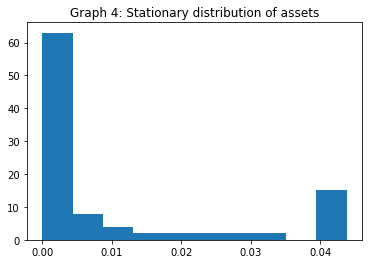

In [4]:
# Report the endogenous distribution of wealth. 

#STEP 1: Stationary distribution of wealth. 
am_ddp = DiscreteDP(am.R, am.Q, am.β)
results = am_ddp.solve(method='policy_iteration')
# Compute the stationary distribution
stationary_probs = results.mc.stationary_distributions[0]
# Extract the marginal distribution for assets
asset_probs = asset_marginal(stationary_probs, am.a_size, am.z_size)

#PLOT
plt.hist(asset_probs)
plt.title('Graph 4: Stationary distribution of assets')

In [5]:
#REPORT SOME STATISTICS


def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

print('Aggregate wealth:'"{0:.2f}".format(np.sum(asset_probs)))
print('Average assets:'"{0:.4f}".format(np.mean(asset_probs)))
print('Standard deviation assets:'"{0:.4f}".format(np.std(asset_probs)))
print('Gini coefficient:'"{0:.4f}".format(gini(asset_probs)))
print('80/20 ratio:'"{0:.2f}".format(np.percentile(asset_probs,80)/np.percentile(asset_probs,20)))
order=sorted(asset_probs)
top1=order[99]/np.sum(order)
top10=np.sum(order[90:99])/np.sum(order)
bottom50=np.sum(order[0:50])/np.sum(order)
middle=np.sum(order[50:90])/np.sum(order)
print('Top 1% share:'"{0:.2f}".format(top1))
print('Top 10% share:'"{0:.2f}".format(top10))
print('Bottom 50% share:'"{0:.2f}".format(bottom50))
print('Middle class share:'"{0:.2f}".format(middle))

Aggregate wealth:1.00
Average assets:0.0100
Standard deviation assets:0.0152
Gini coefficient:0.7220
80/20 ratio:3186.25
Top 1% share:0.04
Top 10% share:0.37
Bottom 50% share:0.01
Middle class share:0.57


Notice that if we compare that with the Chapter 11 of the Handbook Table1 we have some differences. The gini in net worth there is 0.78. The sare of the top 1% is 0.33 and not 0.04. This is the already known limitation of this model. It is unable to generate the actual levels of inequality. Even if in this case we have generated a very acceptable level of inequality.  